# Introduction to DiffPrivLib

[DiffPrivLib](https://diffprivlib.readthedocs.io/en/latest/index.html) is a python library dedicated to differential privacy and machine learning. It is based on `scikit-learn` library. 

Some other [introduction notebooks](https://github.com/IBM/differential-privacy-library/tree/main/notebooks) are available directly in the official library repository.

## Step 1: Install the Library

Diffprivlib is available on pypi, it can be installed via the pip command. We will use the latest version of the library to date: version 0.6.6.

In [1]:
!pip install diffprivlib==0.6.6

Defaulting to user installation because normal site-packages is not writeable


## Step 2: Load and Prepare Data

### Load penguin dataset
In this notebook, we will work with the [penguin dataset]("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") from [seaborn datasets](https://github.com/mwaskom/seaborn-data).
We load the dataset via pandas in a dataframe `df`.

In [1]:
import pandas as pd

In [2]:
path_to_data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(path_to_data)

We can look at the first rows of the dataframe to get to know the data:

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Handle null values
DiffPrivLib does not allow null values so we will have to remove or convert them. For simplicity, we will just drop the rows with null values from the dataset.

In [4]:
print(f"{df.shape[0]} rows before dropping nulls")
df = df.dropna()
print(f"{df.shape[0]} rows after dropping nulls")

344 rows before dropping nulls
333 rows after dropping nulls


### Encode columns for Machine Learning

In the following analysis, we will use the `sex` column as a feature column. We encode the `MALE` and `FEMALE` strings in numbers that the models will the able to use.

In [5]:
df["sex"] = df["sex"].map({"MALE": 0, "FEMALE": 1})

In [6]:
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1


## Step 3: Logistic Regression with DiffPrivLib

We want to predict penguin's species based on bill length, bill depth, flipper length, body mass and sex. 
Therefore, we will do a multiclass logistic regression.

We first split the data between features and target (to predict).

In [7]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
target_columns = ['species']

In [8]:
feature_data = df[feature_columns]
label_data = df[target_columns]

And then split the data to get a training and a testing set with the [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#train-test-split) from scikit-learn.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
TEST_SIZE = 0.2
RANDOM_STATE = 1 

x_train, x_test, y_train, y_test = train_test_split(
    feature_data,
    label_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)
y_train = y_train.to_numpy().ravel()

Then we define the logistic regression pipeline [see doc](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#logistic-regression):

In [11]:
from diffprivlib import models

In [12]:
log_reg = models.LogisticRegression(epsilon = 1.0)

And fit it on the training set:

In [13]:
dpl_pipeline = log_reg.fit(x_train, y_train)

/home/bfs/.local/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:231: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


### Pipeline with logistic regression only (no standard scaler)

We see that we get a `PrivacyLeakWarning` warning because we did not specify the `data_norm` parameter. 

Differential privacy mechanisms need to know how much one individual’s record can change the model. In the case of the `LogisticRegression`, this depends on the maximum $L2$ norm of any row, which in turn depends on the size of feature vectors. `data_norm` is that bound: The maximum L2 norm of any single row (feature vector) in the dataset. 

If it is not specified, DiffPrivLib will infer if from the training data. This may leak information about the dataset (e.g. what the max value was), hence the PrivacyLeakWarning. To avoid that, we should decide on `data_norm` based on domain knowledge before looking at the data.

As common knowledge (without looking at the data), we know that:
- bill length $\in [30.0, 65.0]$,
- bill depth $\in [13.0, 23.0]$,
- flipper length $\in [150.0, 250.0]$,
- body mass $\in [2000.0, 7000.0]$,
- sex $\in [0, 1]$.

Formally, for a row $x = (x_1, \ldots, x_d)$, its L2 norm is $\|x\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}$.

The $L2$ norm of a row $x$ can be bounded using the feature maximum values:

$$
\|x\|_2 = \sqrt{ (\text{max bill length})^2 + (\text{max bill depth})^2 + (\text{max flipper length})^2 + (\text{max body mass})^2 + (\text{max sex})^2 }
$$

Writing it in a metadata dictionnary, we can then compute the `data_norm`:

In [14]:
import numpy as np

In [15]:
metadata_bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'flipper_length_mm': {'lower': 150.0, 'upper': 250.0},
    'body_mass_g': {'lower': 2000.0, 'upper': 7000.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

In [16]:
# TODO: compute the data_norm
# data_norm = ...

# Correction
data_norm = np.sqrt(sum(v['upper']**2 for v in metadata_bounds.values()))
print("data_norm =", data_norm)

data_norm = 7004.802281292456


We rewrite the model pipeline with the `data_norm`

In [17]:
log_reg = models.LogisticRegression(epsilon = 1.0, data_norm=data_norm)

Fit it on the training set

In [18]:
log_reg = log_reg.fit(x_train, y_train)

And assess its score (mean accuracy) on the testing set [doc here](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LogisticRegression.score):

In [19]:
score = log_reg.score(x_test, y_test)
score

0.6119402985074627

### Pipeline with standard scaler before logistic regression

In the previous model, we trained logistic regression without feature scaling.  
Since the features have very different ranges (for example, body mass in the thousands versus sex as a binary 0/1), this can cause several issues:

- the optimizer may converge more slowly  
- model coefficients can become unbalanced  
- in the case of differential privacy, very large row norms can occur, which increases the amount of noise added  

To address this, we will build a pipeline that first scales the data using a 
[`StandardScaler`](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#standard-scaler), and then fits a logistic regression.  

Scaling the features ensures they are on a comparable range, which improves optimization and reduces row norms.  
This leads to better performance and more accurate differentially private estimates.  

---

Unlike logistic regression, the `StandardScaler` does not take a `data_norm` parameter.  
Instead, it requires `bounds` for each feature in order to determine the sensitivity and calibrate the amount of noise to add.  

For a given feature, the sensitivity is defined as $sens = \text{max} - \text{min}$.

For example, consider the feature `bill_length_mm` with bounds in $[30.0, 65.0]$, the sensitivity is $sens = 65.0 - 30.0 = 35.0$.

If we use the Laplace mechanism, the privatized query for this feature would be  

$$
M(S) = q(S) + \text{Lap}\left(0, \frac{35.0}{\epsilon}\right)
$$

where $\epsilon$ is the privacy budget.

We will write a `DiffPrivLib` pipeline with two steps: 
- A `StandardScaler`, which will take the raw data as input and requires information about data `bounds`.
- A `LogisticRegression`, which will take the scaled data as input and requires a `scaled_data_norm` upper bounds of the scaled data.

The pipeline will look like this:

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
dpl_pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds= ...)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm = ...))
])

First, we have to find the data bounds of the standard scaler. Use the `get_bounds` function to instantiate them.

In [22]:
def get_bounds(metadata_bounds, columns):
    lower = [metadata_bounds[col]["lower"] for col in columns]
    upper = [metadata_bounds[col]["upper"] for col in columns]
    return (lower, upper)

In [27]:
# TODO: compute the feature_bounds of the input data
# feature_bounds = get_bounds(..., ...)

# Correction
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
feature_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 250.0, 7000.0, 1.0])

Then we have to find the `scaled_data_norm` of the data in output of the `StandardScaler` and input of the `LogisticRegression`.

By definition, after scaling with `StandardScaler`, each feature is centered to mean 0 and scaled by its standard deviation.

Assuming that the data of each column is Gaussian distribution and according to the [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule), around $99.7%$ of the data should be between $-3$ and $3$ after the scaling. Thus, we take a security margin and set the bounds as $[-4, 4]$ for each column. You can now compute the `scaled_data_norm` assuming all data is within $[-4, 4]$.

In [28]:
STD_BOUND = 4

In [29]:
# TODO: compute the scaled_data_norm
# scaled_data_norm = ...

# Correction
scaled_data_norm = np.sqrt(len(feature_columns) * (STD_BOUND**2))
print("scaled_data_norm =", scaled_data_norm)

scaled_data_norm = 8.94427190999916


We are now ready to define the pipeline with all the `bounds` and `data_norm` required by Differential Privacy.

In [31]:
# TODO: Complete pipeline and train it on the training data.
#pipeline_with_scaler = Pipeline([
#    ('scaler', ...),
#    ('classifier', ...)
#])
#pipeline_with_scaler = dpl_pipeline_with_scaler.fit(..., ...)

# Correction
pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds = feature_bounds)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm = scaled_data_norm))
])
pipeline_with_scaler = pipeline_with_scaler.fit(x_train, y_train)

And evaluate the score of this new model on the test data:

In [33]:
# TODO: Evaluate the score of this new pipeline
#sc_score = ...

# Correction
sc_score = pipeline_with_scaler.score(x_test, y_test)
sc_score

0.6268656716417911

### Privacy loss budget accountant

Another important parameter in DiffPrivLib is an `accountant`. It enables to track the spent budget accross multiple steps in a pipeline and/or accross multiple pipelines.

Therefore the same `accountant` instance of `BudgetAccountant` must be provided as input argument of the query. 

We rewrite here the previous pipeline with the `accountant`.

In [26]:
from diffprivlib import BudgetAccountant

In [27]:
accountant = BudgetAccountant()

dpl_pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=dpl_bounds, accountant=accountant)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm=new_data_norm, accountant=accountant))
])

With the `.total()` method, we can see the budget spent by the models. For now it was not fitted on the data so the budget is 0.

In [28]:
accountant.total()

(epsilon=0, delta=0.0)

We train the model on the data and check the budget again:

In [29]:
dpl_pipeline_with_scaler = dpl_pipeline_with_scaler.fit(x_train, y_train)
accountant.total()

(epsilon=1.5, delta=0.0)

As expected the budget from both steps is spent 0.5 + 1.0 = 1.5 epsilon.

### Use the model for prediction

We can use the model to predict a species depending on the feature values. 

We try to predict for three cases on female penguins:
- the smallest possible value for all features (lower bound)
- the biggest possible value for all features (upper bound)
- the medium value for all features

In [30]:
x_to_predict_dict = {}
for col in feature_columns:
    lower = bounds[col]['lower']
    upper = bounds[col]['upper']
    midpoint = (lower + upper) / 2
    x_to_predict_dict[col] = [lower, upper, midpoint]

x_to_predict = pd.DataFrame(x_to_predict_dict)
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,30.0,13.0,150.0,2000.0,0.0
1,65.0,23.0,150.0,7000.0,1.0
2,47.5,18.0,150.0,4500.0,0.5


In [31]:
predictions = dpl_pipeline_with_scaler.predict(x_to_predict)
x_to_predict["predictions"] = predictions
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,30.0,13.0,150.0,2000.0,0.0,Chinstrap
1,65.0,23.0,150.0,7000.0,1.0,Gentoo
2,47.5,18.0,150.0,4500.0,0.5,Gentoo


## Step 4: Clustering KMeans

DiffPrivLib allows to use many other models. We will show here a second example with a K-Means clustering [(see doc)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#k-means). 

We will do 6 clusters on the features 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g' and 'sex' and see which what cluster emerges. As it is unsupervised learning, there is no target column and we do not do a training and testing set.

In [32]:
N_CLUSTERS = 3

In [33]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
feature_data = df[feature_columns]

In [34]:
dpl_bounds = get_bounds(bounds, columns=feature_columns)
dpl_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 150.0, 7000.0, 1.0])

In [ ]:
after_scaler_bounds = ([-STD_BOUND]*len(feature_columns), [STD_BOUND]*len(feature_columns))

### StandardScaler and KMeans

In [35]:
accountant = BudgetAccountant()

kmeans_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=dpl_bounds, accountant=accountant)),
    ('kmeans', models.KMeans(n_clusters = N_CLUSTERS, epsilon = 5.0, bounds=([-3, -3, -3, -3, -3], [3, 3, 3, 3, 3]), accountant=accountant)),
])

Let's fit the K-Meand model on the clusters

In [36]:
# TODO: Fit the K-Mean pipeline
#kmeans_pipeline = ...

# Correction
kmeans_pipeline = kmeans_pipeline.fit(feature_data)
kmeans_pipeline

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,0.5
,bounds,"(array([ 30.,...2000., 0.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount...0), (5.0, 0)])"


We can look at the score of the model, which is the opposite of the value of X on the K-means objective.

In [37]:
kmeans_pipeline.score(feature_data)

-834912.0659591873

And use the model to predict the clusters:

In [38]:
# TODO: Predict clusters on feature_data with K-Mean pipeline
#predictions = ...

# Correction
predictions = kmeans_pipeline.predict(feature_data)

In [39]:
df["predictions"] = predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,1


We can plot the results to study the clusters

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def plot_clusters(df, x, y, cluster_col="predictions", style_col="species"):
    """
    Plot two features colored by cluster predictions and shaped by species.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features, cluster predictions, and species.
    x : str
        Feature name for the x-axis.
    y : str
        Feature name for the y-axis.
    cluster_col : str, default="predictions"
        Column name with cluster assignments.
    style_col : str, default="species"
        Column name for marker style (e.g., species).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=cluster_col,
        style=style_col,
        palette="deep",
        s=80
    )
    plt.title(f"DP KMeans Clustering: {x} vs {y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

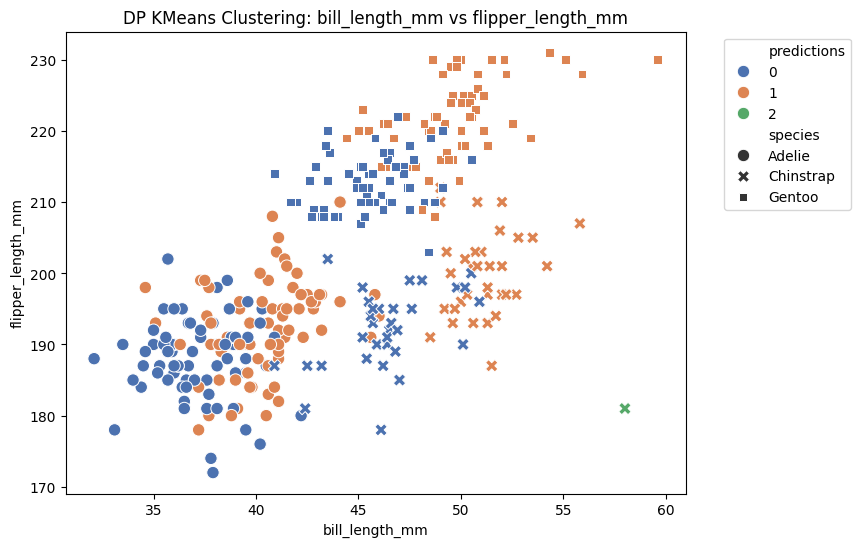

In [42]:
plot_clusters(df, x="bill_length_mm", y="flipper_length_mm")

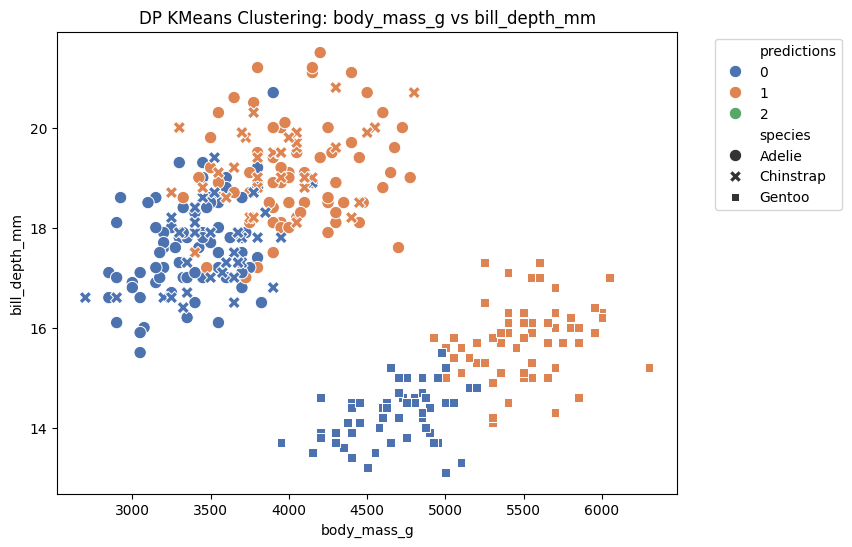

In [43]:
plot_clusters(df, x="body_mass_g", y="bill_depth_mm")

Feel free to try various number of cluster options, feature selection and axis to plot!

### KMeans after PCA and StandardScaler

Let's try do do a dimensionality reduction to two components with a PCA before K-Means to improve the clustering.

In [54]:
N_COMPONENTS = 2

In [55]:
bounds_after_scaler = ([-3]*len(feature_columns), [3]*len(feature_columns))
scaled_sensitivities = [3.0 - (-3.0)] * len(feature_columns)
data_norm_after_scaler = np.sqrt(sum(s**2 for s in scaled_sensitivities))

In [56]:
accountant = BudgetAccountant()

pca_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=dpl_bounds, accountant=accountant)),
    ('pca', models.PCA(n_components=N_COMPONENTS, epsilon=3.0, bounds=bounds_after_scaler, data_norm=data_norm_after_scaler, accountant=accountant)),
])

We use [fit transform](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.PCA.fit_transform) to fit the model with feature_data and apply directly the dimensionality reduction on it.

In [57]:
pca_feature_data = pca_pipeline.fit_transform(feature_data)
pca_feature_data.shape

(333, 2)

This outputs 2 columns that we add to our dataframe.

In [58]:
df[["pca_1", "pca_2"]] = pd.DataFrame(pca_feature_data, index=df.index)
df.head(1)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,pca_1,pca_2,after_pca_predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,1,25.055217,1.227239,1


We now train a K-Mean clustering on the the principal components:

In [59]:
pca_bounds = ([df["pca_1"].min(), df["pca_2"].min()], [df["pca_1"].max(), df["pca_2"].max()])
kmeans_model = models.KMeans(n_clusters = N_CLUSTERS, epsilon = 2.0, bounds=pca_bounds, accountant=accountant)

In [60]:
# TODO: fit kmean on principal components
#kmeans_model = ...

# Correction
kmeans_model = kmeans_model.fit(df[["pca_1", "pca_2"]])
kmeans_model

,n_clusters,3
,epsilon,2.0
,bounds,"(array([15.939... 0.92441083]), ...)"
,random_state,None
,accountant,"BudgetAccount...0), (2.0, 0)])"


In [61]:
# TODO: Predict clusters on principal compoents with K-Mean pipeline
#predictions = ...

# Correction
after_pca_predictions = kmeans_model.predict(df[["pca_1", "pca_2"]])

In [62]:
df["after_pca_predictions"] = after_pca_predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,pca_1,pca_2,after_pca_predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,1,25.055217,1.227239,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,0,29.903653,3.119898,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,0,38.875535,3.895308,1
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,0,36.895622,3.522647,1
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,1,34.037280,1.812206,1


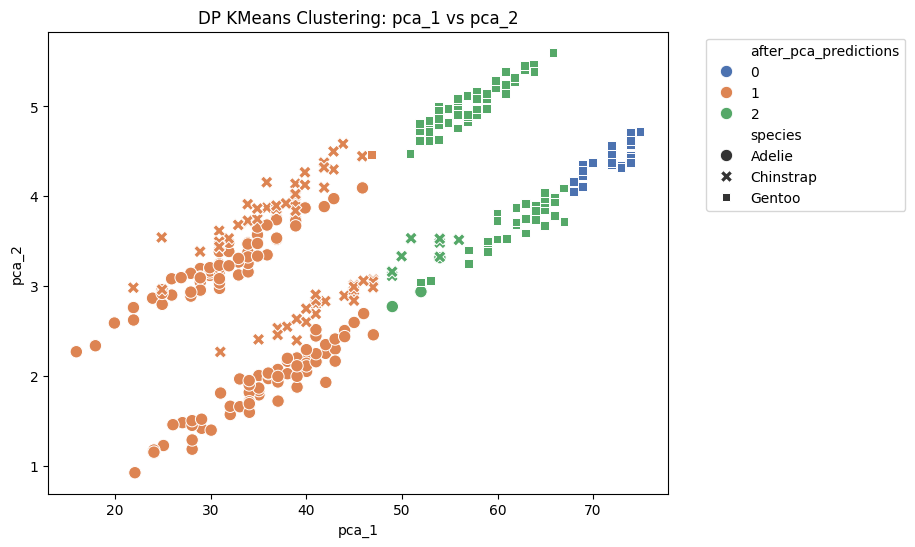

In [63]:
plot_clusters(df, x="pca_1", y="pca_2", cluster_col="after_pca_predictions")

Again, feel free to try various number of principal components, cluster options, feature selection and axis to plot!

Let's now check what was the total budget spent by the scaler, pca and k-means models.

In [65]:
# TODO: Get epsilon and delta
# Correction
accountant.total()

(epsilon=5.5, delta=0.0)

## Step 5: On your Own

DiffPrivLib also provides additional models:
- Gaussian Naive Bayes, 
- Random Forest Classifier,
- Decision Tree Classifier and
- Linear Regressions.

Using these models is very similar to the examples shown here. Apart from the parameters already introduced (`epsilon`, `bounds` and `data_norm`), no additional differentially private settings are required.

Feel free to experiment with these models on your own!